<a href="https://colab.research.google.com/github/kennyerss/csci451-project/blob/main/code/CS451.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#need to import Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/Shareddrives/"

# choose where you want your project files to be saved
project_folder = "CSCI451/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place

create_and_set_working_directory(project_folder)

## Image Visualization

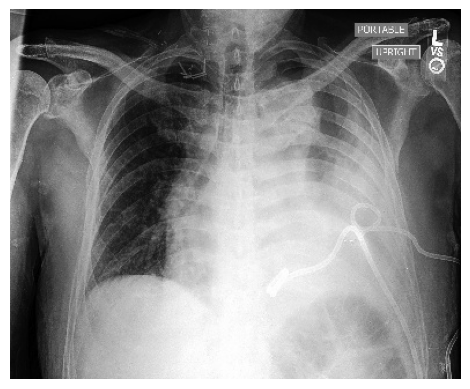

In [3]:
#This just will show the images

import cv2
from matplotlib import pyplot as plt

img = cv2.imread('/content/drive/Shareddrives/CSCI451/train/patient00142/study3/view1_frontal.jpg')
#img = cv2.imread('/content/drive/MyDrive/chexpert_small/train/patient00974/study1/view1_frontal.jpg')
# cv2.imshow()
plt.imshow(img)
plt.axis("off")
plt.show()

## File reading tests

In [ ]:
from os import walk
for (dirpath, dirnames, filenames) in walk("content/drive/Shareddrives/CSCI451/train/"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
#     print("File name: ", filenames)

In [ ]:
# DO NOT RUN THIS

"""
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

dataset = datasets.ImageFolder('/content/drive/MyDrive/chexpert_small/train/', transform=transform)
"""

## Data Analysis

df_train_race holds our data set of patient ID and race.

In [4]:
# import our race data set and load as a dataframe

import pandas as pd

df_train_race = pd.read_excel('/content/drive/Shareddrives/CSCI451/chexpert_race.xlsx')
df_race_sorted = df_train_race.sort_values(by=['PATIENT'],ignore_index=True)
df_race_sorted = df_race_sorted.dropna()
df_race_sorted

,PATIENT,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY
0,patient00001,Female,68,Other,Non-Hispanic/Non-Latino
1,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino
2,patient00003,Male,41,"White, non-Hispanic",Non-Hispanic/Non-Latino
3,patient00004,Female,20,Black or African American,Non-Hispanic/Non-Latino
4,patient00005,Male,33,White,Non-Hispanic/Non-Latino
...,...,...,...,...,...
65396,patient65731,Female,64,White,Non-Hispanic/Non-Latino
65397,patient65732,Female,0,Asian,Non-Hispanic/Non-Latino
65398,patient65735,Female,1,White,Non-Hispanic/Non-Latino
65399,patient65739,Female,44,Unknown,Non-Hispanic/Non-Latino


['Other' 'White, non-Hispanic' 'Black or African American' 'White'
 'Native Hawaiian or Other Pacific Islander' 'Asian' 'Asian, non-Hispanic'
 'Unknown' 'Native American, non-Hispanic' 'Race and Ethnicity Unknown'
 'White, Hispanic' 'Other, Hispanic' 'Black, non-Hispanic'
 'American Indian or Alaska Native' 'Patient Refused'
 'Other, non-Hispanic' 'Pacific Islander, Hispanic' 'Black, Hispanic'
 'Pacific Islander, non-Hispanic' 'White or Caucasian' 'Asian, Hispanic'
 'Native American, Hispanic' 'Asian - Historical Conv']
White: 36768
 Asian: 7061
 Black: 3147
 Native American: 181
 Pacific Islander: 881
 Other/Unknown: 16817


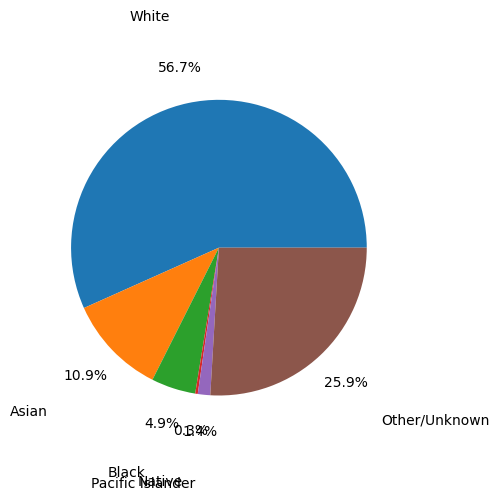

In [5]:
# print the unique labels for race - we need to make some determinations here
print(df_race_sorted['PRIMARY_RACE'].unique())
white_no = (df_race_sorted['PRIMARY_RACE'].str.contains('White')).sum()
black_no = (df_race_sorted['PRIMARY_RACE'].str.contains('Black')).sum()
asian_no = (df_race_sorted['PRIMARY_RACE'].str.contains('Asian')).sum()
native_no = (df_race_sorted['PRIMARY_RACE'].str.contains('Native American')).sum()
native_no += (df_race_sorted['PRIMARY_RACE'].str.contains('Indian')).sum()
islander_no = (df_race_sorted['PRIMARY_RACE'].str.contains('Pacific')).sum()
rest_no = len(df_race_sorted) - white_no - black_no - asian_no - native_no - islander_no

print('White: ' + str(white_no) + '\n Asian: ' + str(asian_no) + '\n Black: ' + str(black_no) + '\n Native American: ' + str(native_no) + '\n Pacific Islander: '
+ str(islander_no) + '\n Other/Unknown: ' + str(rest_no))

labels = ['White', 'Asian', 'Black', 'Native', 'Pacific Islander', 'Other/Unknown']
sizes = [white_no, asian_no, black_no, native_no, islander_no, rest_no]

plt.pie(sizes, labels = labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=1.6)
plt.show()


In [6]:
dk = df_train_race.groupby(['GENDER', 'PRIMARY_RACE']).mean()
dk

<ipython-input-6-56d3decd4222>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dk = df_train_race.groupby(['GENDER', 'PRIMARY_RACE']).mean()


AGE_AT_CXR
GENDER PRIMARY_RACE                                         
Female American Indian or Alaska Native            56.855422
       Asian                                       61.089804
       Asian - Historical Conv                     25.000000
       Asian, Hispanic                             60.000000
       Asian, non-Hispanic                         63.362667
       Black or African American                   55.641553
       Black, Hispanic                             54.545455
       Black, non-Hispanic                         60.887029
       Native American, Hispanic                   71.250000
       Native American, non-Hispanic               55.818182
       Native Hawaiian or Other Pacific Islander   50.019465
       Other                                       55.001051
       Other, Hispanic                             57.885922
       Other, non-Hispanic                         56.272727
       Pacific Islander, Hispanic                  57.000000
       Pacific Islander, non-Hispanic              60.844444
       Patient Refused                             54.409091
       Race and Ethnicity Unknown                  60.310212
       Unknown                                     59.574136
       White                                       64.096811
       White or Caucasian                          37.333333
       White, Hispanic                             59.041322
       White, non-Hispanic                         67.988264
Male   American Indian or Alaska Native            54.546875
       Asian                                       60.323556
       Asian, Hispanic                             73.250000
       Asian, non-Hispanic                         62.407240
       Black or African American                   54.075443
       Black, Hispanic                             55.000000
       Black, non-Hispanic                         53.776978
       Native American, Hispanic                   45.111111
       Native American, non-Hispanic               49.300000
       Native Hawaiian or Other Pacific Islander   54.032258
       Other                                       52.828869
       Other, Hispanic                             49.538240
       Other, non-Hispanic                         59.725664
       Pacific Islander, Hispanic                  47.000000
       Pacific Islander, non-Hispanic              52.877551
       Patient Refused                             54.325581
       Race and Ethnicity Unknown                  57.626587
       Unknown                                     57.316144
       White                                       62.296407
       White or Caucasian                          29.500000
       White, Hispanic                             50.898396
       White, non-Hispanic                         63.368680

In [7]:
# Counting how many patients are classified under each race
df_train_race.value_counts(['PRIMARY_RACE'])

PRIMARY_RACE                             
White                                        29901
Other                                         8510
White, non-Hispanic                           6556
Asian                                         6235
Unknown                                       4315
Black or African American                     2613
Race and Ethnicity Unknown                    2535
Other, Hispanic                               1105
Asian, non-Hispanic                            817
Native Hawaiian or Other Pacific Islander      783
Black, non-Hispanic                            517
White, Hispanic                                308
Other, non-Hispanic                            201
Patient Refused                                152
American Indian or Alaska Native               147
Pacific Islander, non-Hispanic                  94
Native American, non-Hispanic                   21
Black, Hispanic                                 17
Native American, Hispanic               

<BarContainer object of 6 artists>

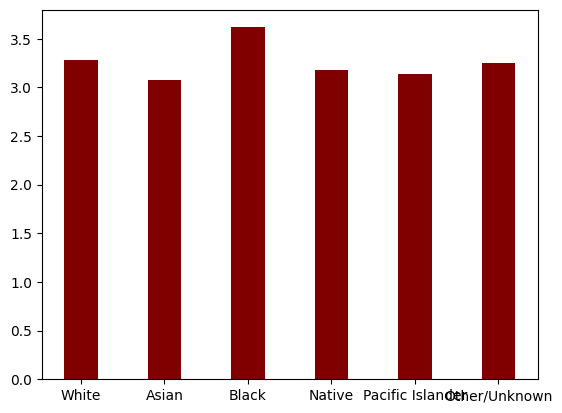

In [ ]:
# for i in range(35100):
import os

# total number of people in each race
white = 0
black = 0
native = 0
asian = 0
pacific = 0
other = 0

# total number of revisits for each race
white_visits = 0
black_visits = 0
native_visits = 0
asian_visits = 0
pacific_visits = 0
other_visits = 0

for i in range(35100):
  path = '/content/drive/Shareddrives/CSCI451/train/' + df_race_sorted.iloc[i]['PATIENT'] + '/'
  if os.path.exists(path):
    subfolders = next(os.walk(path))[1]
    num_subfolders = len(subfolders) # this is the number of studies this patient is involved in
    race = df_race_sorted.iloc[i]['PRIMARY_RACE'] # race of patient

    if 'White' in race:
      white += 1
      white_visits += num_subfolders

    if 'Black' in race:
      black += 1
      black_visits += num_subfolders
    
    if 'Asian' in race:
      asian += 1
      asian_visits += num_subfolders
    
    if 'Native American' in race or 'Indian' in race:
      native += 1
      native_visits += num_subfolders
    
    if 'Pacific' in race:
      pacific += 1
      pacific_visits += num_subfolders
    
    else:
      other += 1
      other_visits += num_subfolders

  else:
    continue

In [ ]:
i = 0
path = '/content/drive/Shareddrives/CSCI451/train/' + df_race_sorted.iloc[i]['PATIENT'] + '/'
if os.path.exists(path):
  subfolders = next(os.walk(path))[1]
  num_subfolders = len(subfolders)
num_subfolders

1

In [8]:
#print the unique labels for ethnicity
print(df_train_race['ETHNICITY'].unique())

['Non-Hispanic/Non-Latino' 'Hispanic/Latino' 'Unknown' nan
 'Patient Refused' 'Hispanic' 'Not Hispanic']


In [9]:
#subset data by the "Other" listed for Race
df_train_race[df_train_race['PRIMARY_RACE'] == 'Other']

,PATIENT,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY
1,patient48289,Female,39,Other,Hispanic/Latino
13,patient51575,Male,68,Other,Hispanic/Latino
32,patient28670,Male,63,Other,Hispanic/Latino
53,patient65275,Female,59,Other,Non-Hispanic/Non-Latino
61,patient54887,Male,74,Other,Hispanic/Latino
...,...,...,...,...,...
65386,patient33297,Female,40,Other,Hispanic/Latino
65390,patient15562,Female,50,Other,Hispanic/Latino
65395,patient32620,Female,21,Other,Hispanic/Latino
65396,patient65702,Male,1,Other,Hispanic/Latino


df_patients holds a csv of image links with sex, age, other features related to their hospitalization. Notice that the patient ID is inside the text for the links. Also, one patient can have multiple images from different times. Images are in two categories frontal and lateral (front of body vs. side of body).

In [10]:
df_patients = pd.read_csv('/content/drive/Shareddrives/CSCI451/train.csv')
df_patients

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0


In [11]:
#need to sort df_train_race by patient ID, otherwise just annoying to index

#df_train_race = pd.read_excel('/content/drive/Shareddrives/CSCI451/chexpert_race.xlsx')
df_race_sorted = df_train_race.sort_values(by=['PATIENT'],ignore_index=True)
df_race_sorted = df_race_sorted.dropna()
#df_race_sorted = df_race_sorted[df_race_sorted["PRIMARY_RACE" == "Patient Refused"]]

df_race_sorted 

,PATIENT,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY
0,patient00001,Female,68,Other,Non-Hispanic/Non-Latino
1,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino
2,patient00003,Male,41,"White, non-Hispanic",Non-Hispanic/Non-Latino
3,patient00004,Female,20,Black or African American,Non-Hispanic/Non-Latino
4,patient00005,Male,33,White,Non-Hispanic/Non-Latino
...,...,...,...,...,...
65396,patient65731,Female,64,White,Non-Hispanic/Non-Latino
65397,patient65732,Female,0,Asian,Non-Hispanic/Non-Latino
65398,patient65735,Female,1,White,Non-Hispanic/Non-Latino
65399,patient65739,Female,44,Unknown,Non-Hispanic/Non-Latino


In [12]:
#again, df_patients['PATIENT'] holds links for the file directory, here I split so instead I can have the patient ID
df_patients['PATIENT'] = [df_patients['Path'][i].split("/")[2] for i in range(df_patients.shape[0])]

#I then merge the patient race with df_race_sorted, which will give me the patient ID - race
df_patients_race = pd.merge(df_patients,df_race_sorted,on='PATIENT')
"""
#check
for index, row in df_patients_race[206949:].iterrows():
  race_sorted_index = df_race_sorted.index[df_race_sorted["PATIENT"] == row["PATIENT"]].tolist()
  if (len(race_sorted_index) != 1):
    print("error!")
    break
  i = race_sorted_index[0]
  if not (row['PATIENT'] in row['Path']):
    print(row,"patient error!")
    break
  if not (row['ETHNICITY'] == df_race_sorted["ETHNICITY"][i]):
    print(row,"ethnicity error!",row['ETHNICITY'],df_race_sorted["ETHNICITY"][i])
    break
  if not (row['PRIMARY_RACE'] == df_race_sorted["PRIMARY_RACE"][i]):
    print(row,"race error!")
    break
  if not (row['Sex'] == df_race_sorted["GENDER"][i]):
    print(row,"sex error!")
    break
"""

#there is a gender error for patient 51668, index 202352
# gender error for patient 54170, index 206312
# gender error for patient 54565, index 206948

def race_to_num(string):
  if 'White' in string:
    return 0
  elif 'Black' in string:
    return 1
  elif 'Asian' in string:
    return 2
  else:
    return 3

df_patients_race["RACE_NUM"] = [race_to_num(df_patients_race["PRIMARY_RACE"][i]) for i in range(len(df_patients_race))]

df_patients_race

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pleural Effusion,Pleural Other,Fracture,Support Devices,PATIENT,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY,RACE_NUM
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,patient00001,Female,68,Other,Non-Hispanic/Non-Latino,3
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,patient00003,Male,41,"White, non-Hispanic",Non-Hispanic/Non-Latino,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220992,CheXpert-v1.0-small/train/patient64535/study1/...,Male,60,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,patient64535,Male,60,Black or African American,Non-Hispanic/Non-Latino,1
220993,CheXpert-v1.0-small/train/patient64536/study2/...,Female,61,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,patient64536,Female,61,Other,Hispanic/Latino,3
220994,CheXpert-v1.0-small/train/patient64536/study1/...,Female,61,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,patient64536,Female,61,Other,Hispanic/Latino,3
220995,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,1.0,NaN,NaN,NaN,patient64537,Male,59,Black or African American,Non-Hispanic/Non-Latino,1


In [13]:
df_patients_bwa = df_patients_race[df_patients_race['PRIMARY_RACE'].str.contains('White|Black|Asian')==True]
df_patients_bwa

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pleural Effusion,Pleural Other,Fracture,Support Devices,PATIENT,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY,RACE_NUM
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,patient00002,Female,87,"White, non-Hispanic",Non-Hispanic/Non-Latino,0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,patient00003,Male,41,"White, non-Hispanic",Non-Hispanic/Non-Latino,0
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,patient00004,Female,20,Black or African American,Non-Hispanic/Non-Latino,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220990,CheXpert-v1.0-small/train/patient64533/study2/...,Male,75,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,patient64533,Male,75,White,Non-Hispanic/Non-Latino,0
220991,CheXpert-v1.0-small/train/patient64534/study1/...,Male,63,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,patient64534,Male,63,White,Non-Hispanic/Non-Latino,0
220992,CheXpert-v1.0-small/train/patient64535/study1/...,Male,60,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,patient64535,Male,60,Black or African American,Non-Hispanic/Non-Latino,1
220995,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,...,1.0,NaN,NaN,NaN,patient64537,Male,59,Black or African American,Non-Hispanic/Non-Latino,1


In [14]:
print(df_patients_bwa['PRIMARY_RACE'].unique())
print(df_patients_bwa['RACE_NUM'].unique())

['White, non-Hispanic' 'Black or African American' 'White' 'Asian'
 'Asian, non-Hispanic' 'White, Hispanic' 'Black, non-Hispanic'
 'Black, Hispanic' 'White or Caucasian' 'Asian, Hispanic'
 'Asian - Historical Conv']
[0 1 2]


In [15]:
df_patients_bwa.groupby("RACE_NUM").size()

RACE_NUM
0    125483
1     11961
2     23272
dtype: int64

In [16]:
df_patients_bwa[:90000].groupby("RACE_NUM").size()

RACE_NUM
0    69517
1     7427
2    13056
dtype: int64

In [17]:
#df_patients_bwa_equal = pd.concat([df_patients_bwa[:90000].groupby("RACE_NUM").get_group(0).sample(n=7000),df_patients_bwa[:90000].groupby("RACE_NUM").get_group(1).sample(n=7000),df_patients_bwa[:90000].groupby("RACE_NUM").get_group(2).sample(n=7000)])
df_patients_bwa_equal = pd.concat([df_patients_bwa[:90000].groupby("RACE_NUM").get_group(0)[:7000],df_patients_bwa[:90000].groupby("RACE_NUM").get_group(1)[:7000],df_patients_bwa[:90000].groupby("RACE_NUM").get_group(2)[:7000]])
df_patients_bwa_equal = df_patients_bwa_equal.sample(21000)
df_patients_bwa_equal

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Pleural Effusion,Pleural Other,Fracture,Support Devices,PATIENT,GENDER,AGE_AT_CXR,PRIMARY_RACE,ETHNICITY,RACE_NUM
27299,CheXpert-v1.0-small/train/patient06745/study2/...,Female,52,Frontal,PA,NaN,NaN,NaN,1.0,NaN,...,0.0,NaN,NaN,NaN,patient06745,Female,50,Black or African American,Non-Hispanic/Non-Latino,1
1559,CheXpert-v1.0-small/train/patient00372/study3/...,Female,44,Frontal,AP,NaN,NaN,1.0,1.0,NaN,...,1.0,NaN,NaN,1.0,patient00372,Female,44,White,Non-Hispanic/Non-Latino,0
53903,CheXpert-v1.0-small/train/patient13202/study6/...,Male,69,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,1.0,patient13202,Male,69,Asian,Non-Hispanic/Non-Latino,2
61946,CheXpert-v1.0-small/train/patient15103/study2/...,Male,41,Frontal,PA,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,patient15103,Male,47,Asian,Non-Hispanic/Non-Latino,2
49939,CheXpert-v1.0-small/train/patient12280/study3/...,Female,60,Frontal,PA,1.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,patient12280,Female,61,Asian,Non-Hispanic/Non-Latino,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9182,CheXpert-v1.0-small/train/patient02315/study4/...,Male,37,Frontal,PA,NaN,NaN,1.0,0.0,NaN,...,-1.0,NaN,NaN,1.0,patient02315,Male,39,White,Non-Hispanic/Non-Latino,0
45739,CheXpert-v1.0-small/train/patient11254/study3/...,Male,46,Lateral,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,patient11254,Male,47,Asian,Non-Hispanic/Non-Latino,2
62118,CheXpert-v1.0-small/train/patient15150/study6/...,Female,50,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,patient15150,Female,50,Asian,Non-Hispanic/Non-Latino,2
2999,CheXpert-v1.0-small/train/patient00738/study17...,Female,69,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,1.0,patient00738,Female,69,Asian,Non-Hispanic/Non-Latino,2


In [18]:
len(df_patients_bwa_equal["PATIENT"].unique())

4930

In [19]:
df_patients_bwa_equal.shape

(21000, 25)

In [20]:
df_patients_bwa_equal.groupby("RACE_NUM").size()

RACE_NUM
0    7000
1    7000
2    7000
dtype: int64

In [79]:
i = 0

import os

#ran already, found anomaly only with patient 11019
"""
for index, row in df_patients_bwa_equal.iterrows():
    row_path_list = row['Path'].split("/")
    row_path = os.path.join("/content/drive/Shareddrives/CSCI451/train",row_path_list[2],row_path_list[3],row_path_list[4])
    
    dir_path = os.path.join("/content/drive/Shareddrives/CSCI451/train",row_path_list[2],row_path_list[3])
    os.chdir(dir_path)

    if (i % 1000 == 0):
      print(i)

    if not os.path.isfile(row_path_list[4]):
      print(row_path)

    #print(row_path)

    #print(i)
    
    
    #if not os.path.isfile(row_path):
    #  print(row_path)
    i += 1
"""

'\nfor index, row in df_patients_bwa_equal.iterrows():\n    row_path_list = row[\'Path\'].split("/")\n    row_path = os.path.join("/content/drive/Shareddrives/CSCI451/train",row_path_list[2],row_path_list[3],row_path_list[4])\n    \n    dir_path = os.path.join("/content/drive/Shareddrives/CSCI451/train",row_path_list[2],row_path_list[3])\n    os.chdir(dir_path)\n\n    if (i % 1000 == 0):\n      print(i)\n\n    if not os.path.isfile(row_path_list[4]):\n      print(row_path)\n\n    #print(row_path)\n\n    #print(i)\n    \n    \n    #if not os.path.isfile(row_path):\n    #  print(row_path)\n    i += 1\n'

## Data Preparation and Loading

In [23]:
import sys
import os
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim

import torchvision.transforms as transforms
import torchvision

from fastprogress import master_bar, progress_bar

from PIL import Image


#I used a lot of code from https://www.kaggle.com/code/hmchuong/chexpert-pytorch-densenet121?scriptVersionId=18314696&cellId=15

class ChestXrayDataset(Dataset):
  #creates a Torch Dataset that we can use to do machine learning on

  def __init__(self,folder_dir,dataframe,image_size,normalization):
    #a lot of this function is 
    # folder_dir is the directory path to the data
    # dataframe holds patient info and labels
    # it takes in our image labels

    self.image_paths=[]
    self.image_labels=[]

    #This transforms our image, I think we would also need normalization
    image_transformation = [
        #transforms.Grayscale(num_output_channels=1), #ONLY USE FOR PYTORCH XRAY
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor()
    ]

    #this normalizes using some constants from imagenet
    if normalization:
      #ONLY COMMENT OUT FOR PYTORCH XRAY
      #image_transformation.append(transforms.Normalize(IMAGENET_MEAN,IMAGENET_STD))
      image_transformation.append(transforms.Normalize([0.485],[0.229]))

    self.image_transformation = transforms.Compose(image_transformation)

    #this will index through all the patients from 000001, so forth, adding images from study1
    for index, row in dataframe.iterrows():
      
      #image_path = os.path.join(folder_dir,Path(row['PATIENT']),Path('study1'),Path('view1_frontal.jpg'))

      #here I use lateral and frontal images
      row_path_list = row['Path'].split("/")
      image_path = os.path.join(folder_dir,row_path_list[2],row_path_list[3],row_path_list[4])
      
      #if (os.path.isfile(image_path)):
      self.image_paths.append(image_path)
      #else:
      #  continue
      #in this case I've hard-coded the image_labels to be if the patient is Black or not
      #NOTICE that I'm append a list to a list here
      
      image_label = []

      image_label.append(int(row["RACE_NUM"]))
      
      """
      if ( row["PRIMARY_RACE"] ==  'White' or row["PRIMARY_RACE"] == 'White, non-Hispanic' or row["PRIMARY_RACE"] == 'White or Caucasian'):
        image_label.append(1)
      #else:
      #  image_label.append(0)
      elif ( row["PRIMARY_RACE"] ==  'Black or African American' or row["PRIMARY_RACE"] == 'Black, non-Hispanic'):
        image_label.append(2)
      #else:
      #  image_label.append(0)

      elif ( row["PRIMARY_RACE"] ==  'Asian' or row["PRIMARY_RACE"] == 'Asian, non-Hispanic' or row["PRIMARY_RACE"] == 'Asian - Historical Conv' or row['PRIMARY_RACE'] == 'Asian - Historical Conv'):
        image_label.append(3)
      else:
        image_label.append(0)
      """

      #DELETE THIS IF NOT USING TORCH XRAY
      #for i in range(17):
      #  image_label.append(5)
      
      self.image_labels.append(image_label)

      #self.image_labels.append([int(1*((row["PATIENT"] == 'Black or African American') | (row["PATIENT"] == 'Black, non-Hispanic')))])
    
    #print(self.image_paths)

  def __len__(self):
    #I think this is necessary for other things
    return len(self.image_paths)

  def __getitem__(self,index):
    #This is also just necessary for other parts

    # Read image
    image_path = self.image_paths[index]
    #ONLY COMMENT OUT FOR PYTORCH XRAY
    image_data = Image.open(image_path).convert("RGB")
    #image_data = Image.open(image_path)
    image_data = self.image_transformation(image_data)
      
    return image_data, torch.FloatTensor(self.image_labels[index])



In [24]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 50                           
#BATCH_SIZE = 1728 #ONLY FOR PYTORCH XRAY VISION
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 2                              # Maximum number of training epochs

Define the dataset object here

In [110]:
#train_dataset = ChestXrayDataset("/content/drive/Shareddrives/CSCI451/train", df_train_race_mod, race_is_white, IMAGE_SIZE, True)

#train the dataset with the first 2000 images, this includes frontal and lateral images
train_dataset = ChestXrayDataset("/content/drive/Shareddrives/CSCI451/train", df_patients_bwa_equal[:6000], IMAGE_SIZE, True)

#print(ChestXrayDataset.len(train_dataset))

In [111]:
import numpy as np
print(train_dataset.image_labels)
print(train_dataset.image_paths)
print("dataset length", len(train_dataset))

[[1], [0], [2], [2], [2], [0], [1], [0], [2], [1], [0], [2], [2], [1], [0], [2], [2], [0], [1], [2], [2], [0], [0], [2], [2], [1], [0], [0], [2], [0], [2], [1], [1], [1], [0], [2], [0], [0], [1], [2], [1], [2], [0], [1], [1], [2], [0], [2], [2], [1], [0], [0], [1], [1], [2], [1], [2], [1], [1], [0], [2], [0], [1], [0], [1], [2], [2], [0], [2], [0], [0], [1], [1], [2], [1], [0], [2], [2], [1], [2], [2], [0], [1], [0], [2], [1], [0], [1], [1], [1], [2], [1], [2], [2], [1], [0], [2], [2], [2], [0], [0], [2], [0], [0], [0], [0], [2], [1], [0], [1], [0], [2], [0], [1], [2], [0], [2], [0], [2], [0], [1], [0], [2], [0], [0], [0], [2], [1], [2], [1], [0], [1], [1], [1], [2], [0], [0], [2], [0], [1], [0], [1], [2], [0], [2], [2], [1], [1], [2], [1], [1], [0], [2], [2], [0], [2], [0], [2], [2], [0], [0], [2], [0], [0], [0], [2], [0], [1], [1], [2], [2], [0], [1], [0], [0], [2], [2], [0], [2], [0], [2], [2], [1], [0], [0], [0], [1], [0], [0], [0], [2], [0], [0], [0], [0], [1], [2], [1], [1], [0],

Create the loader for the dataset here - basically it is nice to have this so we can load the data in batches when we need instead of loading the entire dataset onto RAM, which is costly and slow.

In [112]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, pin_memory=True)

In [113]:
#I believe that this functions as a test - if this block returns an error, there is a problem with dataloading
for data, label in train_dataloader:
    print(data.size())
    print(label.size())
    break

torch.Size([50, 3, 224, 224])
torch.Size([50, 1])


In [114]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [ ]:
"""
def train(model,  data_loader, optimizer, k_epochs = 1, print_every = 2000):

    begin = time.time()
    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss() 

    # optimizer is Adam, which does fancier stuff with the gradients
    
    for epoch in range(k_epochs): 

        running_loss = 0.0

        i = 0

        #for i, data in enumerate(data_loader, 0):
        for data,label in data_loader:  
            #print(data.size())

            # extract a batch of training data from the data loader
            X = data
            #only flatten for binary classification
            y = torch.flatten(label)
            #y = label
            y = y.to(torch.long)
            X = X.to(device)
            y = y.to(device)

            

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)

            #print("Here!")
            #print(y_hat)
            #print(y)

            loss = loss_fn(y_hat, y)

            #print("All good here!")

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1: 
            #if True:   
                print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], training loss: {running_loss / print_every:.3f}')
                #print(loss.item())
                running_loss = 0.0

            #print(i)
            
            i += 1
    end = time.time()
    print(f'Finished training in {round(end - begin)}s')
"""

'\ndef train(model,  data_loader, optimizer, k_epochs = 1, print_every = 2000):\n\n    begin = time.time()\n    # loss function is cross-entropy (multiclass logistic)\n    loss_fn = nn.CrossEntropyLoss() \n\n    # optimizer is Adam, which does fancier stuff with the gradients\n    \n    for epoch in range(k_epochs): \n\n        running_loss = 0.0\n\n        i = 0\n\n        #for i, data in enumerate(data_loader, 0):\n        for data,label in data_loader:  \n            #print(data.size())\n\n            # extract a batch of training data from the data loader\n            X = data\n            #only flatten for binary classification\n            y = torch.flatten(label)\n            #y = label\n            y = y.to(torch.long)\n            X = X.to(device)\n            y = y.to(device)\n\n            \n\n            # zero out gradients: we\'re going to recompute them in a moment\n            optimizer.zero_grad()\n\n            # compute the loss (forward pass)\n            y_hat = mo

In [ ]:
"""
from scipy.sparse import coo_array
def test(model, data_loader):
    correct = 0
    total = 0
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training

    i = 0

    with torch.no_grad():
        #for data in data_loader:
        for data, label in data_loader:

            #print(data.size())
            #print(label.size())

            X = data
            # only flatten if binary setup
            y = torch.flatten(label)
            #y = label
            #X, y = data
            X = X.to(device)
            y = y.to(device)
            
            # run all the images through the model
            y_hat = model(X)

            # the class with the largest model output is the prediction
            _, predicted = torch.max(y_hat.data, 1)

            # compute the accuracy
            total += y.size(0)
            correct += (predicted == y).sum().item()

            i += 1

    print(i)
    print(correct)
    print(total)
    print(f'Test accuracy: {100 * correct // total} %')
"""

In [115]:
import torch.optim as optim

def train(model, trainloader, optimizer, k_epochs = 1, print_every = 2000):

    begin = time.time()

    # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss() 

    # optimizer is Adam, which does fancier stuff with the gradients
    #optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)

            #print(y)
            
            #need to flatten y - this holds labels for each image in the batch, but as a list of a list
            y = torch.flatten(y)
            y = y.to(torch.long)
            
            #print(y)

            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)

            #print(y_hat)

            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
                print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], loss: {running_loss / print_every:.3f}')
                running_loss = 0.0

    end = time.time()
    print(f'Finished training in {round(end - begin)}s')

In [116]:
def test(model, testloader):
    correct = 0
    total = 0
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training

    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, label in testloader:
            #X, y = data
            X = data
            y = label
            X = X.to(device)

            y = torch.flatten(label)
            y = y.to(torch.long)
            y = y.to(device)

            print(y)
            
            # run all the images through the model
            y_hat = model(X)

            #print(y_hat)

            # the class with the largest model output is the prediction
            _, predicted = torch.max(y_hat.data, 1)

            print("predicted: ",predicted)

            y_pred.extend(predicted.data.cpu().numpy()) 
        
            y_true.extend(y.data.cpu().numpy())

            # compute the accuracy
            total += y.size(0)
            correct += (predicted == y).sum().item()

            #print(total,correct)

    print(f'Test accuracy: {100 * correct // total} %')

    return y_pred, y_true

In [ ]:
!pip install torchxrayvision

In [ ]:
from torchvision import models
import torchxrayvision as xrv
import skimage, torch, torchvision

# instead train only the parameters of the final layer
# can be around 50% faster

#"""
#pretrained resnet 18 model with weights from IMAGENET
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.to(device)

# no gradients for any of the model parameters, so no updates

for param in model.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
#out_ftrs = 2 #for binary classification
out_ftrs = 4
model.fc = nn.Linear(num_ftrs, out_ftrs)

model = model.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)
#"""

"""
#from pytorch xrayvision use a pretrained model
model = xrv.models.DenseNet(weights="densenet121-res224-nih") # NIH chest X-ray8
model = model.to(device)

# no gradients for any of the model parameters, so no updates

for param in model.parameters():
  param.requires_grad = False

print(model.classifier.in_features,model.classifier.out_features)

# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = model.classifier.in_features
#out_ftrs = 2 #for binary classification
#out_ftrs = 4
#model.classifier = nn.Linear(num_ftrs, out_ftrs)

print(model.classifier.in_features,model.classifier.out_features)

model = model.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
"""

In [ ]:
from torchsummary import summary

summary(model, (3,224,224))

In [ ]:
import time

#previous value
df_val_race_mod = df_train_race.sort_values(by=['PATIENT'])[2000:2400]
#df_val_race_mod = df_train_race.sort_values(by=['PATIENT'])[10000:12000]

race_is_black_val = ((df_val_race_mod['PRIMARY_RACE'] == 'Black or African American')  | (df_val_race_mod['PRIMARY_RACE'] =='Black, non-Hispanic'))
#race_is_black.sum()

race_is_white_val = ((df_val_race_mod['PRIMARY_RACE'] == 'White')  | (df_val_race_mod['PRIMARY_RACE'] =='White, non-Hispanic') | (df_val_race_mod['PRIMARY_RACE'] =='White or Caucasian'))
print(race_is_white_val.sum())

#val_dataset = ChestXrayDataset("/content/drive/MyDrive/chexpert_small/train", df_val_race_mod, race_is_black_val, IMAGE_SIZE, True)

val_dataset = ChestXrayDataset("/content/drive/Shareddrives/CSCI451/train", df_patients_race[10000:11500], race_is_white_val, IMAGE_SIZE, True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

train(model, train_dataloader, optimizer, k_epochs = 100, print_every = 20)
test(model,val_dataloader)

In [ ]:
df_val_race_mod = df_train_race.sort_values(by=['PATIENT'])[2000:2321]

race_is_black_val = ((df_val_race_mod['PRIMARY_RACE'] == 'Black or African American')  | (df_val_race_mod['PRIMARY_RACE'] =='Black, non-Hispanic'))

print(race_is_black_val.sum())
print(df_val_race_mod.shape)
print(100*(1-race_is_black_val.sum()/df_val_race_mod.shape[0]))

val_dataset = ChestXrayDataset("/content/drive/Shareddrives/CSCI451/train", df_patients_race[2000:2321], race_is_white_val, IMAGE_SIZE, True)

print(BATCH_SIZE)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

test(model,val_dataloader)

In [37]:
!pip install --upgrade efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=58262bce1aa38bccc9a9a29d10244adde59e68618795f0da858efde7376ba27c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
import time

from efficientnet_pytorch import EfficientNet
#UNCOMMENT THIS OF COURSE
#model = EfficientNet.from_pretrained('efficientnet-b4',num_classes=4)
#model.to(device)

val_dataset = ChestXrayDataset("/content/drive/Shareddrives/CSCI451/train", df_patients_bwa_equal[10000:10400], IMAGE_SIZE, True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_dataloader, optimizer, k_epochs = 5, print_every = 40)
y_pred_enet, y_true_enet = test(model,val_dataloader)

[epoch: 1, batches:    40], loss: 0.700


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')
predicted:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')
predicted:  tensor([2, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')
predicted:  tens

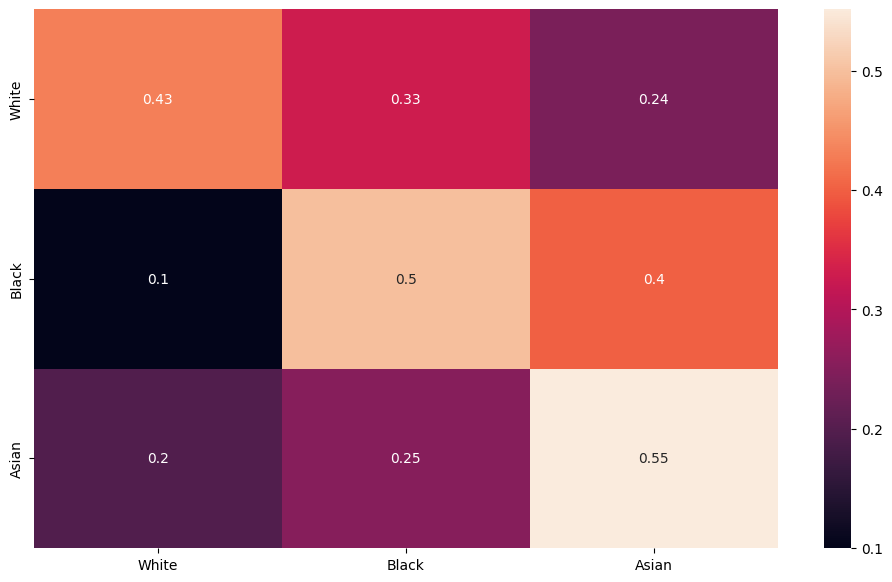

In [107]:
val_dataset = ChestXrayDataset("/content/drive/Shareddrives/CSCI451/train", df_patients_bwa[87000:87400], IMAGE_SIZE, True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

#train(model, train_dataloader, optimizer, k_epochs = 5, print_every = 20)
y_pred_enet, y_true_enet = test(model,val_dataloader)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true_enet, y_pred_enet)

classes = ['White','Black','Asian']

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [104]:
unique_patients_bwa_equal = df_patients_bwa_equal['PATIENT'].unique().tolist()
unique_patients_bwa_equal.sort()
unique_patients_bwa_equal[-1]

'patient28041'

tensor([1, 0, 0, 0, 2, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        2, 2], device='cuda:0')
predicted:  tensor([1, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2,
        2, 2, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2,
        2, 2], device='cuda:0')
tensor([2, 2, 2, 3, 0, 0, 0, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0')
predicted:  tensor([2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2,
        0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0,
        1, 2], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2,
        2, 2], device='cuda:0')
predicted:  tens

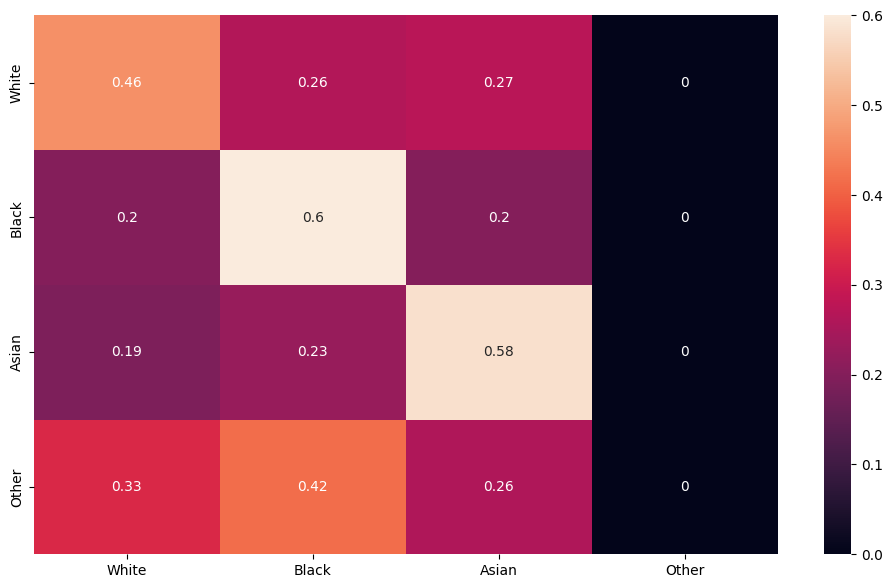

In [108]:
val_dataset = ChestXrayDataset("/content/drive/Shareddrives/CSCI451/train", df_patients_race[120000:120400], IMAGE_SIZE, True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

#train(model, train_dataloader, optimizer, k_epochs = 5, print_every = 20)
y_pred_enet, y_true_enet = test(model,val_dataloader)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true_enet, y_pred_enet)

classes = ['White','Black','Asian','Other']

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')

tensor([0, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1,
        0, 1, 1, 0, 0, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2,
        1, 1], device='cuda:0')
predicted:  tensor([0, 2, 2, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 1,
        0, 2, 2, 2, 0, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2,
        1, 1], device='cuda:0')
tensor([1, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1,
        2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0, 1,
        2, 1], device='cuda:0')
predicted:  tensor([1, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 2, 1, 0, 0, 1,
        2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 2, 2, 1, 0, 1, 2, 1,
        2, 1], device='cuda:0')
tensor([2, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 1,
        0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0, 2, 1,
        2, 0], device='cuda:0')
predicted:  tens

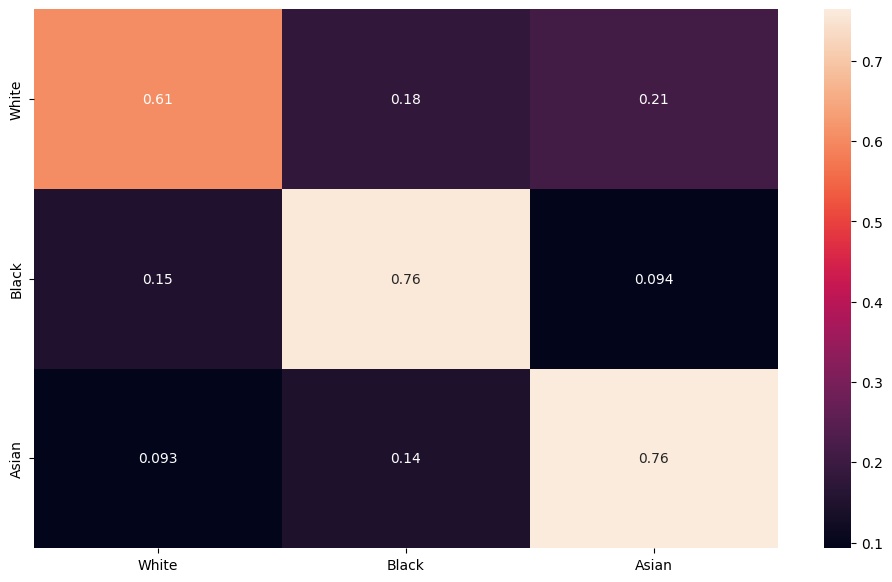

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true_enet, y_pred_enet)

classes = ['White','Black','Asian']

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')

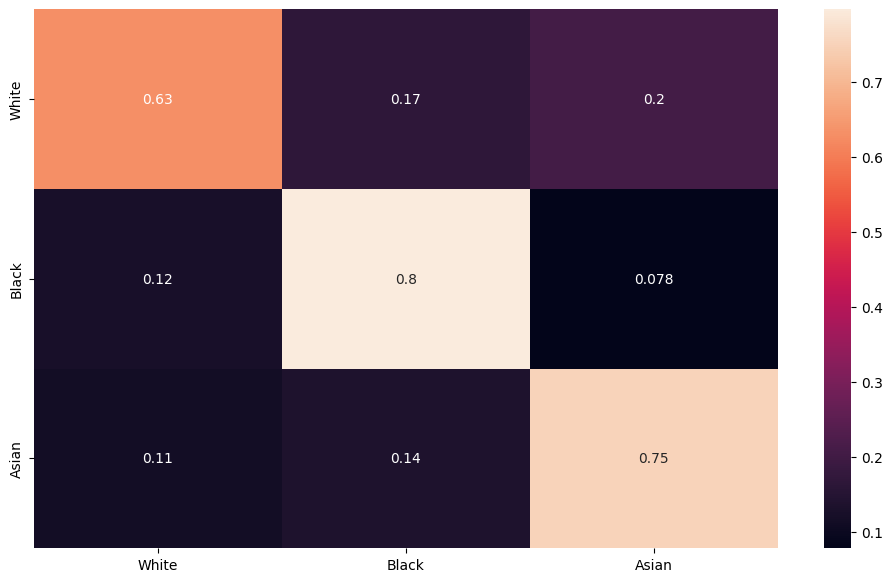

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true_enet, y_pred_enet)

classes = ['White','Black','Asian']

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.savefig('output.png')

Model Optimization

In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import time

def train_epoch(model, trainloader, optimizer, loss_fn, print_every = 2000):

  training_loss = 0.0
  for i, data in enumerate(trainloader, 0):

      # extract a batch of training data from the data loader
      X, y = data
      X = X.to(device)

      #need to flatten y - this holds labels for each image in the batch, but as a list of a list
      y = torch.flatten(y)
      y = y.to(torch.long)

      y = y.to(device)

      # zero out gradients: we're going to recompute them in a moment
      optimizer.zero_grad()

      # compute the loss (forward pass)
      y_hat = model(X)

      loss = loss_fn(y_hat, y)

      # compute the gradient (backward pass)
      loss.backward()

      # Adam uses the gradient to update the parameters
      optimizer.step()

      # print statistics
      training_loss += loss.item()

  return training_loss

def test_epoch(model, testloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data, label in testloader:
          #X, y = data
          X = data
          y = label
          X = X.to(device)

          y = torch.flatten(label)
          y = y.to(torch.long)
          y = y.to(device)

          # run all the images through the model
          y_hat = model(X)

          # the class with the largest model output is the prediction
          _, predicted = torch.max(y_hat.data, 1)

          #print("predicted: ",predicted)

          # compute the accuracy
          total += y.size(0)
          correct += (predicted == y).sum().item()
  return correct/total
    
def optimize(train_dataset,lr_params,max_epochs=100,batch_size=BATCH_SIZE):
  """
  So far this only optimizes the learning rate, ideally it would optimize more
  https://medium.com/dataseries/k-fold-cross-validation-with-pytorch-and-sklearn-d094aa00105f
  a helpful example
  """

  begin = time.time()

  loss_fn = nn.CrossEntropyLoss()

  k_folds = 5

  splits=KFold(n_splits=k_folds,shuffle=True,random_state=42)

  #best_param = lr_params[0]
  #best_train_loss = 10.0
  #best_valid_loss = 10.0
  
  best_train_losses = []
  best_valid_losses = []

  for lr_param in lr_params:

    print("Param value: ",lr_param)

    #holds best losses in each fold for particular param value
    train_losses = []
    valid_losses = []

    for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):

      print("Fold: ",fold)

      train_sampler_epoch = SubsetRandomSampler(train_idx)
      val_sampler_epoch = SubsetRandomSampler(val_idx)
      train_loader_epoch = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler_epoch)
      val_loader_epoch = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler_epoch)
      
      #pretrained resnet 18 model with weights from IMAGENET
      model = models.resnet18(weights='IMAGENET1K_V1')
      num_ftrs = model.fc.in_features
      out_ftrs = 4
      model.fc = nn.Linear(num_ftrs, out_ftrs)
      model = model.to(device)

      optimizer = optim.Adam(model.fc.parameters(), lr=lr_param)

      best_epoch_train_loss = 100.0
      best_epoch_val_loss = 0.0

      for epoch in range(max_epochs):
      
        train_loss = train_epoch(model, train_loader_epoch, optimizer, loss_fn)
        val_loss = test_epoch(model, val_loader_epoch)

        #print(lr_param,"Epoch: ",epoch," train loss: ",train_loss," test loss: ",val_loss)

        if train_loss < best_epoch_train_loss:
          best_epoch_train_loss = train_loss

        #bit of a mislabel here, in this case, the val loss is actually an accuracy score, not a loss
        if val_loss > best_epoch_val_loss:
          best_epoch_val_loss = val_loss

      train_losses.append(best_epoch_train_loss)
      valid_losses.append(best_epoch_val_loss)

      print("Best train loss: ",best_epoch_train_loss," best test loss: ",best_epoch_val_loss)

    #best losses amongst fold
    best_train_losses.append(sum(train_losses)/len(train_losses))
    best_valid_losses.append(sum(valid_losses)/len(valid_losses))

  print("Best param: ", lr_params)
  print("Best train loss: ",best_train_losses)
  print("Best test loss: ",best_valid_losses)

  end = time.time()
  print(f'Finished optimizing in {round(end - begin)}s')


In [ ]:
lr_params = [0.0001,0.0005,0.001,0.005,0.01]
optimize(train_dataset,lr_params,max_epochs=25)

In [ ]:
device

In [ ]:
df_val_race_mod = df_train_race.sort_values(by=['PATIENT'])[2000:2321]
df_val_race_mod

In [ ]:
test(model,val_dataloader)

In [ ]:
print(running_loss)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F #this is for relu

class ConvNet(nn.Module): #inherits from nn.module

  def __init__(self):
    super().__init__() #run init method of parent class

    """
    Let's just define the functions we'll use later for forward
    """

    self.conv1 = nn.Conv2d(3, 100, 5) #3 input channels for rgb, 100 convolutional kernels, all size 5 by 5
    self.conv2 = nn.Conv2d(100, 50, 3)
    self.conv3 = nn.Conv2d(50, 20, 3)

    self.pool = nn.MaxPool2d(2,2) #largest pixel value from each 2 by 2 window
    self.fc1 = nn.Linear(13520,80)
    self.fc2 = nn.Linear(80,40)
    self.fc3 = nn.Linear(40,2) #only two outputs for the binary cat/dog label

  def forward(self,x):
    print('x_shape:',x.shape)
    x = self.pool(F.relu(self.conv1(x))) #do kernel convolution to x, then do relu, then do max pooling
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    print('x_shape:',x.shape)

    #DO NOT FORGET TO FLATTEN BEFORE LINEAR LAYERS

    x = torch.flatten(x,1)

    print('x_shape:',x.shape)

    x = F.relu(self.fc1(x))

    print('x_shape:',x.shape)

    x = F.relu(self.fc2(x))

    print('x_shape:',x.shape)

    x = self.fc3(x) #just return the output, no nonlinear lyaers

    print('x_shape:',x.shape)

    return x

model = ConvNet().to(device)

import torch
torch.cuda.empty_cache()

train(model, train_dataloader, optimizer, k_epochs = 100, print_every = 50)

In [ ]:
model = DenseNet121(num_classes = 2 ).to(device)
model.train()
train(model, train_dataloader, optimizer, k_epochs = 100, print_every = 50)

In [ ]:

class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_trained=True):
        """
        Init model architecture
        
        Parameters
        ----------
        num_classes: int
            number of classes
        is_trained: bool
            whether using pretrained model from ImageNet or not
        """
        super().__init__()
        
        # Load the DenseNet121 from ImageNet
        self.net = torchvision.models.densenet121(pretrained=is_trained)
        
        # Get the input dimension of last layer
        kernel_count = self.net.classifier.in_features
        
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        self.net.classifier = nn.Sequential(nn.Linear(kernel_count, num_classes), nn.Sigmoid())
        
    def forward(self, inputs):
        """
        Forward the netword with the inputs
        """
        return self.net(inputs)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
model = DenseNet121(num_classes=2).to(device) #binary classification
model

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Loss function
loss_criteria = nn.BCELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

# Learning rate will be reduced automatically during training
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = LEARNING_RATE_SCHEDULE_FACTOR, patience = LEARNING_RATE_SCHEDULE_PATIENCE, mode = 'max', verbose=True)

In [ ]:
def multi_label_auroc(y_gt, y_pred):
    """ Calculate AUROC for each class

    Parameters
    ----------
    y_gt: torch.Tensor
        groundtruth
    y_pred: torch.Tensor
        prediction

    Returns
    -------
    list
        F1 of each class
    """
    auroc = []
    gt_np = y_gt.to("cpu").numpy()
    pred_np = y_pred.to("cpu").numpy()
    assert gt_np.shape == pred_np.shape, "y_gt and y_pred should have the same size"
    for i in range(gt_np.shape[1]):
        auroc.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return auroc

In [ ]:
def epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb):
    """
    Epoch training

    Paramteters
    -----------
    epoch: int
      epoch number
    model: torch Module
      model to train
    train_dataloader: Dataset
      data loader for training
    device: str
      "cpu" or "cuda"
    loss_criteria: loss function
      loss function used for training
    optimizer: torch optimizer
      optimizer used for training
    mb: master bar of fastprogress
      progress to log

    Returns
    -------
    float
      training loss
    """
    # Switch model to training mode
    model.train()
    training_loss = 0 # Storing sum of training losses
   
    # For each batch
    for batch, (images, labels) in enumerate(progress_bar(train_dataloader, parent=mb)):
        
        # Move X, Y  to device (GPU)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear previous gradient
        optimizer.zero_grad()

        # Feed forward the model
        pred = model(images)
        loss = loss_criteria(pred, labels)

        # Back propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Update training loss after each batch
        training_loss += loss.item()

        mb.child.comment = f'Training loss {training_loss/(batch+1)}'

    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # return training loss
    return training_loss/len(train_dataloader)

In [ ]:
def evaluating(epoch, model, val_loader, device, loss_criteria, mb):
    """
    Validate model on validation dataset
    
    Parameters
    ----------
    epoch: int
        epoch number
    model: torch Module
        model used for validation
    val_loader: Dataset
        data loader of validation set
    device: str
        "cuda" or "cpu"
    loss_criteria: loss function
      loss function used for training
    mb: master bar of fastprogress
      progress to log
  
    Returns
    -------
    float
        loss on validation set
    float
        metric score on validation set
    """

    # Switch model to evaluation mode
    model.eval()

    val_loss = 0                                   # Total loss of model on validation set
    out_pred = torch.FloatTensor().to(device)      # Tensor stores prediction values
    out_gt = torch.FloatTensor().to(device)        # Tensor stores groundtruth values

    with torch.no_grad(): # Turn off gradient
        # For each batch
        for step, (images, labels) in enumerate(progress_bar(val_loader, parent=mb)):
            # Move images, labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Update groundtruth values
            out_gt = torch.cat((out_gt,  labels), 0)

            # Feed forward the model
            ps = model(images)
            loss = loss_criteria(ps, labels)

            # Update prediction values
            out_pred = torch.cat((out_pred, ps), 0)

            # Update validation loss after each batch
            val_loss += loss
            mb.child.comment = f'Validation loss {val_loss/(step+1)}'

    # Clear memory
    del images, labels, loss
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    # return validation loss, and metric score
    return val_loss/len(val_loader), np.array(multi_label_auroc(out_gt, out_pred)).mean()

In [ ]:
import time

In [ ]:
!pip install git+https://github.com/fastai/fastai --upgrade

!pip install git+https://github.com/fastai/fastprogress --upgrade

In [ ]:
df_train_race_val = df_train_race.sort_values(by=['PATIENT'])[501:700]
race_is_black = ((df_train_race_val['PRIMARY_RACE'] == 'Black or African American')  | (df_train_race_val['PRIMARY_RACE'] =='Black, non-Hispanic'))

val_dataset = ChestXrayDataset("/content/drive/MyDrive/chexpert_small/train", df_train_race_val, race_is_black, IMAGE_SIZE, True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep

# Best AUROC value during training
best_score = 0
model_path = "densenet.pth"
training_losses = []
validation_losses = []
validation_score = []


# Config progress bar
mb = master_bar(range(MAX_EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'Validation AUROC']
x = []

nonimproved_epoch = 0
start_time = time.time()

# Training each epoch
for epoch in mb:
    #mb.first_bar.comment = f'Best AUROC score: {best_score}'
    x.append(epoch)

    # Training
    train_loss = epoch_training(epoch, model, train_dataloader, device, loss_criteria, optimizer, mb)
    mb.write('Finish training epoch {} with loss {:.4f}'.format(epoch, train_loss))
    training_losses.append(train_loss)

    # Evaluating
    val_loss, new_score = evaluating(epoch, model, val_dataloader, device, loss_criteria, mb)
    mb.write('Finish validation epoch {} with loss {:.4f} and score {:.4f}'.format(epoch, val_loss, new_score))
    validation_losses.append(val_loss)
    validation_score.append(new_score)

    # Update learning rate
    lr_scheduler.step(new_score)

    # Update training chart
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, validation_score]], [0,epoch+1], [0,1])

    # Save model
    if best_score < new_score:
        mb.write(f"Improve AUROC from {best_score} to {new_score}")
        best_score = new_score
        nonimproved_epoch = 0
        torch.save({"model": model.state_dict(), 
                    "optimizer": optimizer.state_dict(), 
                    "best_score": best_score, 
                    "epoch": epoch, 
                    "lr_scheduler": lr_scheduler.state_dict()}, model_path)
    else: 
        nonimproved_epoch += 1
    if nonimproved_epoch > 10:
        break
        print("Early stopping")
    if time.time() - start_time > 3600*8:
        break
        print("Out of time")

In [ ]:
import json

with open("/var/log/colab-jupyter.log", "r") as fo:
  for line in fo:
    print(json.loads(line)['msg'])

In [ ]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread(train_dataset.image_paths[446],1)
#cv2.imshow()
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
#references https://arxiv.org/pdf/1512.03385.pdf, original resnet paper
# and https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/ for pointers on code
# https://github.com/microsoft/nni/blob/master/examples/trials/cifar10_pytorch/models/resnet.py

import torch
import torch.nn as nn

class Resnet(nn.Module):
  """
  for now I'm doing the 34 version
  """
  def __init__(self, num_classes):

    super(Resnet,self).__init__() #is (Resnet,self) necessary?

    #want to take matrix 224*224 to 112*112, padding 3 ensures that each kernel 
    # centered on pixel in matrix, stride =2 makes it every other pixel, hence dimension is half
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, stride = 2, padding=3), 
      nn.BatchNorm2d(num_features = 64),
      nn.ReLU()
    )
    #now do 3 by 3 max pool, similarly need padding 1 to make sure kernel
    # centered on each pixel, stride=2 make it other pixel, dimension 56*56
    self.maxpool = nn.MaxPool2d(kernel_size = 3,stride=2,padding=1) #not sure why there is padding

    #each time we reduce the size of the matrix by half, hence stride of 2 (for conv2_x, maxpool reduced dimension)
    self.conv2_x = self.make_conv_layer(64,64,kernel_size = 3, stride = 1, num_layers = 3)
    self.conv3_x = self.make_conv_layer(64,128,kernel_size = 3, stride = 2, num_layers = 4)
    self.conv4_x = self.make_conv_layer(128,256,kernel_size = 3, stride = 2, num_layers = 6)
    self.conv5_x = self.make_conv_layer(256,512,kernel_size = 3, stride = 2, num_layers = 3)

    #size is now [512,7,7], want it to be [512,1,1] so kernel size 7
    #self.avgpool = nn.AvgPool2d(kernel_size = 7,stride = 1) #no idea why this is 7
    self.avgpool = nn.AdaptiveAvgPool2d((1,1)) #this is what preloaded resnet34 has

    self.fc = nn.Linear(512,num_classes)

  #this is specific to resnet 34
  def make_conv_layer(self,in_channels, out_channels, kernel_size, stride, num_layers):
    #conv 1 - 64 out, conv2 - 64 in 64 out, 64 in 64 out, 64 in 64 out, conv3 - 64 in 128 out, 128 in 128 out
    
    layer_list = []

    in_ch = in_channels
  
    # first block is input stride, reset are stride of 1

    layer_list.append(ResidualBlock(in_ch,out_channels,kernel_size,stride))
    in_ch = out_channels

    for i in range(1,num_layers):
      layer_list.append(ResidualBlock(in_ch,out_channels,kernel_size,stride=1))

    return nn.Sequential(*layer_list)

  def forward(self,x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.conv2_x(x)
    x = self.conv3_x(x)
    x = self.conv4_x(x)
    x = self.conv5_x(x)
    x = self.avgpool(x)
    
    #x = torch.flatten(x)
    x = x.view(x.size(0), -1) #not sure why but flatten doesn't work
    x = self.fc(x)
    return x


class ResidualBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size,stride):
    """
    Some math, input kernel to conv2_x is [64,56,56], can just do stride 1, size maintained
    Input kernel to conv3_x is [64,56,56] want [128,28,28], after convolutions x is [128,28,28] (stride 2 at first then stride 1),
    But x is still [64,56,56], so no padding, use kernel size 1 with 128 outchannels and stride 2
    """

    super(ResidualBlock,self).__init__()
    #again note padding here is 1 because kernel is 3 by 3
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, stride = stride, padding = 1),
        nn.BatchNorm2d(num_features = out_channels),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(num_features = out_channels) #don't do ReLU here since we might downsample
    )

    self.skip_connection = nn.Sequential() #identity

    #idea here is that skip_connection will add the input x to itself
    # but if stride != 1 or in_channels != out_channels, we need to change dimensions of x
    # so that the dimensions of x after conv1 and conv2 applied
    if stride != 1 or in_channels != out_channels:
      self.skip_connection = nn.Sequential(
          nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride),
          nn.BatchNorm2d(num_features = out_channels)
      )
    self.ReLU = nn.ReLU()

  def forward(self,x):
    x_layer = self.conv1(x)
    x_layer = self.conv2(x_layer)
    x_layer += self.skip_connection(x)
    x_layer = self.ReLU(x_layer)
    return x_layer

    


In [ ]:
from torchsummary import summary
model = Resnet(4)
model
model.to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
    ResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import time

#previous value
df_val_race_mod = df_train_race.sort_values(by=['PATIENT'])[2000:2400]
#df_val_race_mod = df_train_race.sort_values(by=['PATIENT'])[10000:12000]

race_is_black_val = ((df_val_race_mod['PRIMARY_RACE'] == 'Black or African American')  | (df_val_race_mod['PRIMARY_RACE'] =='Black, non-Hispanic'))
#race_is_black.sum()

race_is_white_val = ((df_val_race_mod['PRIMARY_RACE'] == 'White')  | (df_val_race_mod['PRIMARY_RACE'] =='White, non-Hispanic') | (df_val_race_mod['PRIMARY_RACE'] =='White or Caucasian'))
print(race_is_white_val.sum())

#val_dataset = ChestXrayDataset("/content/drive/MyDrive/chexpert_small/train", df_val_race_mod, race_is_black_val, IMAGE_SIZE, True)

val_dataset = ChestXrayDataset("/content/drive/Shareddrives/CSCI451/train", df_patients_race[10000:11000], race_is_white_val, IMAGE_SIZE, True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

train(model, train_dataloader, optimizer, k_epochs = 50, print_every = 40)
test(model,val_dataloader)

210
[epoch: 1, batches:    40], loss: 1.008
[epoch: 1, batches:    80], loss: 0.979
[epoch: 2, batches:    40], loss: 1.010
[epoch: 2, batches:    80], loss: 0.989
[epoch: 3, batches:    40], loss: 0.993
[epoch: 3, batches:    80], loss: 0.992
[epoch: 4, batches:    40], loss: 1.015
[epoch: 4, batches:    80], loss: 0.972
[epoch: 5, batches:    40], loss: 1.016
[epoch: 5, batches:    80], loss: 0.994
[epoch: 6, batches:    40], loss: 1.000
[epoch: 6, batches:    80], loss: 0.989
[epoch: 7, batches:    40], loss: 1.019
[epoch: 7, batches:    80], loss: 0.991
[epoch: 8, batches:    40], loss: 1.007
[epoch: 8, batches:    80], loss: 1.001
[epoch: 9, batches:    40], loss: 0.974
[epoch: 9, batches:    80], loss: 1.016
[epoch: 10, batches:    40], loss: 0.973
[epoch: 10, batches:    80], loss: 1.029
[epoch: 11, batches:    40], loss: 1.002
[epoch: 11, batches:    80], loss: 0.985
[epoch: 12, batches:    40], loss: 1.003
[epoch: 12, batches:    80], loss: 1.021
[epoch: 13, batches:    40], l

In [ ]:
x[2] + [1]*(4-1)